In [1]:
from keras.preprocessing.text import Tokenizer
from gensim.models.fasttext import FastText
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk import WordPunctTokenizer

import wikipedia
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

%matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WorkPC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WorkPC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WorkPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#retrieve the page contents via the content attribute
artificial_intelligence = wikipedia.page("Artificial Intelligence").content
machine_learning = wikipedia.page("Machine Learning").content
deep_learning = wikipedia.page("Deep Learning").content
neural_network = wikipedia.page("Neural Network").content

#The sent_tokenize method returns list of sentences
artificial_intelligence = sent_tokenize(artificial_intelligence)
machine_learning = sent_tokenize(machine_learning)
deep_learning = sent_tokenize(deep_learning)
neural_network = sent_tokenize(neural_network)

#sentences from the four articles are joined together
artificial_intelligence.extend(machine_learning)
artificial_intelligence.extend(deep_learning)
artificial_intelligence.extend(neural_network)

In [3]:
artificial_intelligence[0]

'In computer science, artificial intelligence (AI), sometimes called machine intelligence, is intelligence demonstrated by machines, unlike the natural intelligence displayed by humans and animals.'

Data Preprocessing

In [4]:
#removing punctuations and numbers
#converting words into lowercase
#lemmatizing words to their root form
#stop words and the words with the length less than 4 will be removed from the corpus

import re
from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

def preprocess_text(document):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(document))

        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)

        # Converting to Lowercase
        document = document.lower()

        # Lemmatization
        tokens = document.split()
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word) > 3]

        preprocessed_text = ' '.join(tokens)

        return preprocessed_text

In [5]:
sent = preprocess_text("Artificial intelligence, is the most advanced technology of the present era")
print(sent)

artificial intelligence advanced technology present


In [6]:
final_corpus = [preprocess_text(sentence) for sentence in artificial_intelligence if sentence.strip() !='']
final_corpus[0]

'computer science artificial intelligence sometimes called machine intelligence intelligence demonstrated machine unlike natural intelligence displayed human animal'

In [7]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in final_corpus]
word_tokenized_corpus[0]

['computer',
 'science',
 'artificial',
 'intelligence',
 'sometimes',
 'called',
 'machine',
 'intelligence',
 'intelligence',
 'demonstrated',
 'machine',
 'unlike',
 'natural',
 'intelligence',
 'displayed',
 'human',
 'animal']

Creating Word Representations

In [8]:
# hyperparamteres for fasttext model

#size of the embedding vector
embedding_size = 60 

#size of the number of words occurring before and after the word
#The word embeddings for the input word are learned using these 80 output words 40 words before and after the input word
window_size = 40 

#minimum frequency of a word in the corpus for which the word representations will be generated
min_word = 5

#the most frequently occurring word will be down-sampled by this number
down_sampling = 1e-2

In [9]:
ft_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,                       # 1 for skipgram, 0 for BOW
                      iter=100)

In [10]:
print(ft_model.wv['artificial'])

[-0.42348334 -0.13981    -0.3673555  -0.18530992 -0.42191035  0.32378814
 -0.1759081   0.60020757 -0.33952722  0.05320329  0.0050014   0.17317005
  0.299596    0.30614978 -0.26391652 -0.11150341 -0.08951159 -0.44916818
 -0.2920483  -0.26908073  0.4368828  -0.49914163  0.3102714  -0.3491561
  0.49644873 -0.18974216 -0.09919172 -0.48192358  0.13336301 -0.1491716
  0.24192058  0.15403497 -0.21336807 -0.16339162 -0.15442526  0.13162258
  0.00217823 -0.25798118  0.05528881 -0.03461967  0.29691762  0.03850811
  0.02567223 -0.2405285   0.25997114 -0.30692548  0.3483306  -0.01871014
  0.01123231  0.24865952 -0.14138414 -0.12408929 -0.151892   -0.1260919
  0.1354932  -0.10016061  0.03783804 -0.63229066  0.0226698  -0.1726187 ]


In [11]:
# finding most similar 5 words for some words
semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['artificial', 'intelligence', 'machine', 'network', 'recurrent', 'deep']}

for k,v in semantically_similar_words.items():
    print(k+":"+str(v))

artificial:['intelligence', 'moral', 'simulate', 'neuron', 'neural']
intelligence:['artificial', 'machine', 'question', 'philosophy', 'human']
machine:['learning', 'ethic', 'intelligence', 'concerned', 'ethical']
network:['neural', 'recurrent', 'deep', 'biological', 'layer']
recurrent:['short', 'hopfield', 'convolutional', 'neural', 'network']
deep:['learning', 'speech', 'generative', 'neural', 'recurrent']


In [12]:
# cosine similarity btw words
print(ft_model.wv.similarity(w1='artificial', w2='intelligence'))

0.84678364


Visualizing Word Similarities

In [13]:
from sklearn.decomposition import PCA

all_similar_words = sum([v for k, v in semantically_similar_words.items()], [])

print(all_similar_words)

['intelligence', 'moral', 'simulate', 'neuron', 'neural', 'artificial', 'machine', 'question', 'philosophy', 'human', 'learning', 'ethic', 'intelligence', 'concerned', 'ethical', 'neural', 'recurrent', 'deep', 'biological', 'layer', 'short', 'hopfield', 'convolutional', 'neural', 'network', 'learning', 'speech', 'generative', 'neural', 'recurrent']


In [14]:
print(len(all_similar_words))

30


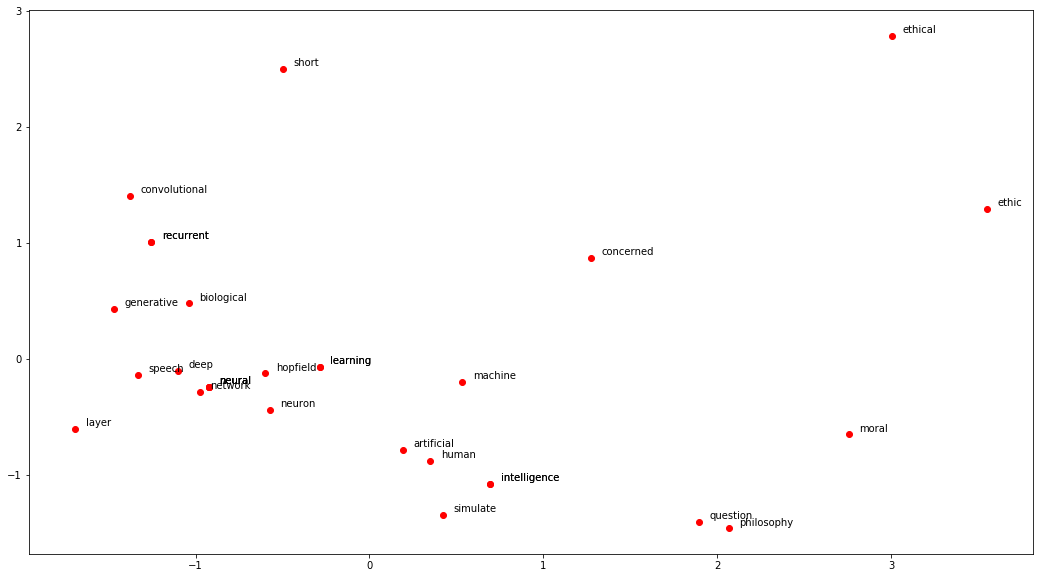

In [15]:
word_vectors = ft_model.wv[all_similar_words]

pca = PCA(n_components=2)

p_comps = pca.fit_transform(word_vectors)
word_names = all_similar_words

plt.figure(figsize=(18, 10))
plt.scatter(p_comps[:, 0], p_comps[:, 1], c='red')

for word_names, x, y in zip(word_names, p_comps[:, 0], p_comps[:, 1]):
    plt.annotate(word_names, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')